In [1]:
import numpy as np
import matplotlib.pyplot as plt

TODO: number the equations,then refer to them in code!
DEFINE {p(\mathbf{x})}
TODO: go into more detail on WHAT exactly we are aiming to do (learn the distribution of x given the data!)

An energy-based model (EMB) takes the form:

$$
q_\theta(\mathbf{x}) = \dfrac{e^ {-E_\theta(\mathbf{x}) } } { \int e^ {-E_\theta(\mathbf{x})} d\mathbf{x}}
$$

where $E_\theta(.)$ is a function returning the 'energy' of $\mathbf{x}$ shaped to capture the likelihood of observing certain $x$. Here we will take $\mathbf{x} \in R^m$, so $\mathbf{x}$ for example could be an image $n \times n$ image as a $|n^2|$ vector. Here $\mathbf{x}$ is a sample (i.e. single image) from the space $\mathbf{X}$ of all possible $n \times n$ images i.e. $\mathbf{X}$ is a random variable $q_\theta(\mathbf{x})$ is a probability distribution over $\mathbf{X}$ given a set of model parameters $\theta$.

Some brief notes on notation. First, we write $\theta$ in the subscript by convention, but to be clear this is a set of parameters on which our model depends (e.g. we could write alternatively as $E(x;\theta)$ or $q(x; \theta)$). Further, the normalising constant in the denominator (also called the 'partition function') is an integral over all $\mathbf{x}$ and so does not depend on $\mathbf{x}$ as input to $q_\theta(\mathbf{x})$. It is sometimes written $Z(\theta)$ to make this lack of dependency clear.

Note that $q_\theta(\mathbf{x})$ takes the form of the Boltzmann distribution:

$$
p(\epsilon_i) = \dfrac { e^{ -\epsilon_i  } } { \sum_i e^{ -\epsilon_i }}
$$

where $ \epsilon_i = \dfrac{ e_i } {k_B T }$ (energy $e$ of state $i$ over the Boltzmann constant $k_B$ and absolute temperature $T$, which are set to $1$ here).



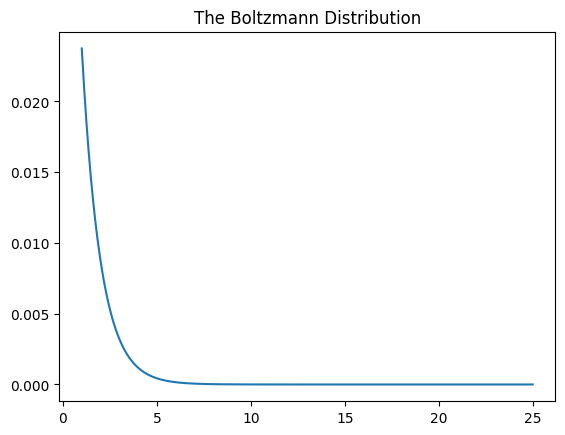

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sample_space = np.linspace(1, 25, 1000)
Z = np.sum(np.exp(-sample_space))

plt.plot(
    sample_space, np.exp(-sample_space) / Z
)
plt.title("The Boltzmann Distribution")
plt.show()

boWe see that the Boltzmann distribution assigns high probability to low energy states.

A key benefit of the EBM framework is that we can use any energy function $E_\theta(\mathbf{x})$ we like to model the likelihood of $\mathbf{x}$. This means we are not restricted to models that return a normalised probability, providing a great deal of flexibility [[1]](https://atcold.github.io/NYU-DLSP20/en/week07/07-1/). As such, can take $E_\theta(\mathbf{x})$ to be any function $ f_\theta : \mathbf{X} \to \mathbb{R} $, typically it a neural network parameterised by $\theta$.

Once the model is trained (i.e. we have learned a distribution over $\mathbf{X}$), we can do a number of cool things:
- Generate new images by sampling from $q(\mathbf{x})$
- Recover lost parts of images by sampling from $q(\mathbf{x})$ with MCMC using the partial images as an initialisation point
- Check if a new, previously unobserved image is likely to have been part of the dataset (e.g. is this picture of a horse a picture of a cat?)

**The objective function**

The Maximum likelihood approach maximises the log probability our model returns for the observed data, given a set of parameters:

$$
\arg\max_{\theta} \ \mathbb{E}_{p(\mathbf{x})} [ \log q_\theta (\mathbf{x}) ]
$$

i.e. we want our model to match the distribution of our observed data as closely as possible. By convention, we will minimise the negative log likelihood:

$$
\arg\min_{\theta} \ -\mathbb{E}_{p(\mathbf{x})} [ \log q_\theta (\mathbf{x}) ]
$$

Let's look at the objective function a little more closely:

\begin{aligned}
L_{\theta} &= -\mathbb{E}_{p(\mathbf{x})} \left[ \log q_\theta (\mathbf{x}) \right] \\
&= \mathbb{E}_{p(\mathbf{x})} \left[E_\theta(\mathbf{x}) \right] + \log \int e^{-E_\theta(\mathbf{x})} \ dx
\end{aligned}

Where the expectation over the second term can be  dropped because it does not depend on $\mathbf{x}$. The form this takes is very interesting and worth thinking about. We want to optimise for parameters that lower the energy for $\mathbf{x}$ according to the probability distribution of the real data (i.e. lower energy for more likely  $\mathbf{x}$). However, we don't want to just globally lower the energy for all $\mathbf{x}$. Therefore, we want to minimise the energy where $p(\mathbf{x})$ is high, and maximise the energy elsewhere.



We will take the partial derivative of the loss function w.r.t $\theta$ ($\nabla_\theta = \dfrac{\partial}{\partial \theta}$) for stochastic gradient descent:

$$
\nabla_\theta L_{\theta} = \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta E_{\theta} (\mathbf{x}) \right] - \mathbb{E}_{q_\theta (\mathbf{x}) } \left[ \nabla_\theta E_\theta(\mathbf{x}) \right]
$$

See **Appendix A** for the derivation.

$\mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta E_{\theta} (\mathbf{x}) \right] = \int p(\mathbf{x}) \nabla_\theta E_{\theta} \ d\mathbf{x}$ For every $\mathbb{b} \in X$ we will plug $\mathbf{x}$ into our energy function $\theta E_{\theta} (\mathbf{x})$ and compute the derivative at that point. We will take an average over all $\mathbf{x}$ weighted by the 'true' probability of observing $\mathbf{x}$ (i.e. in the real world). As we don't have access to the real world, we will estimate this distribution from our observed data.

$ \mathbb{E}_{q_\theta (\mathbf{x}) } \left[ \nabla_\theta E_\theta(\mathbf{x}) \right] = \int q_\theta (\mathbf{x}) \nabla_\theta E_{\theta} \ d\mathbf{x}$ We are doing almost exactly the same thing, but now weighted the derivatives computed from $\mathbf{x}$ by the probability of observing $\mathbf{x}$ according to our model.

Together, this means the stationary points (zero derivative) will occur where our chosen parameters set the model distribution $q_\theta (\mathbf{x})$ equals to the data distribution ${p(\mathbf{x})}$, which makes sense. As the update step is $\theta \leftarrow \eta \nabla_\theta L$, we will move in the direction that reduces energy of the samples at our observed data (reflecting the 'true' data distribution). In contrast, we will move along the positve gradient of the energy at samples drawn from our model (i.e. non-data samples). Together this will 'push' the energy down at the observed data and 'pull' the energy up at random samples drawn from our model distribution (examplin this in more detail).

We will use MCMC to sample from our model distribution and estimate the expectaion (otherwise it's tractable to sample over all possible $x$.


**Contrastive Divergence**

Above, we would have to run MCMC samples (initialise randomly, wait) until convergence. This is extremely slow. Instead, we will use contrastive divergence (e.g. initiaise with data, asmple once). The benefits are much faster and something else. REF shows that when we minimise the negative log liklihood, we are equvilently minising the KL divergence between the true data distribution $p(\mathbf{x})$ and our model distribution $q\theta^\infty(\mathbf{x})$ where $\infty$ indicates we run MCMC samples to infiinite to fully actually have the true distribution before estimating samples:

$$
\arg\min_{\theta}  -\mathbb{E}_{p(\mathbf{x})} \left[ \log q_\theta^\infty(\mathbf{x}) \right] \Leftrightarrow \arg\min_{\theta}  KL( p(\mathbf{x}) || q_\theta^\infty(\mathbf{x}))
$$

See **Appendix B** for the derivation.


In contrastive divergence, we instead only run the MCMC sampler initialised at a data point $mathbb{x_0}$ for $k$ steps, where $k$ is typically very small. This is much faster and performs well. CD thus mimisise sthe ML and an error term:

$$
CD  = KL( p(\mathbf{x}) || q_\theta^\infty(\mathbf{x})) - KL( q_\theta^k(\mathbf{x}) || q_\theta^\infty(\mathbf{x}))
$$

Taking the derivative of this (Appendix C) we find three terms, the last of which we drop due to XXX. So we have the same as the ML but we ignoring the error term and proceeding to minimize:


Together, the steps of our algorithm will be:

TODO:
1) finalise all bits
2) make it more explanatory
3) check the math :(
4) add the code!
5) Move onto the Gaussian version

Below, we do the code which basically follows XXX very closely.





Okay, now we are ready to put everything together (algorithm)

Then, very detailed code as from that tutorial.



**Appendix A**

\begin{aligned}
\nabla_\theta L_{\theta}
&= -\nabla_\theta \mathbb{E}_{p(\mathbf{x})} \left[ \log q_\theta (\mathbf{x}) \right] \\
&= -\nabla_\theta \mathbb{E}_{p(\mathbf{x})} \left[ \log e^{-E_{\theta} (\mathbf{x})} - \log \int e^{-E_\theta(\mathbf{x})} \ d\mathbf{x} \right] \\
&= -\nabla_\theta \mathbb{E}_{p(\mathbf{x})} \left[ -E_{\theta} (\mathbf{x}) \right] - \nabla_\theta \log \int e^{-E_\theta(\mathbf{x})} d\mathbf{x}
\end{aligned}

Looking at the second term (which is constant in $\mathbf{x}$ so we drop the expectation), we can apply the log derivative rule $\nabla_\theta \log f(\theta) = \frac{1}{f(\theta)} \nabla_\theta f(\theta)$ then differentiation under the integral $\nabla_\theta \int f(\theta, \mathbf{x}) \ d\mathbf{x} = \int \nabla_\theta f(\theta, \mathbf{x}) \ d\mathbf{x}$:

\begin{aligned}
\nabla_\theta \log \int e^{-E_\theta(\mathbf{x})} d\mathbf{x}
&= \dfrac{1} { \int e^{-E_\theta(\mathbf{x})} d\mathbf{x}} \nabla_\theta  \int e^{-E_\theta(\mathbf{x})} \ d\mathbf{x} \\
&= \dfrac{1} { \int e^{-E_\theta(\mathbf{x})} d\mathbf{x}}  \int e^{-E_\theta(\mathbf{x})} \nabla_\theta \left( -E_\theta(\mathbf{x}) \right) \ d\mathbf{x} \\
&=  \int \dfrac{e^{-E_\theta(\mathbf{x})}} { \int e^{-E_\theta(\mathbf{x})} d\mathbf{x}}  \nabla_\theta \left( -E_\theta(\mathbf{x}) \right) \ d\mathbf{x} \\
&= \mathbb{E}_{q_\theta (\mathbf{x}) } \left[ -\nabla_\theta E_\theta(\mathbf{x}) \right]
\end{aligned}


We can similarly differentiate under the integral in the first term to move the derivative into the expectation. Together this gives us the Maximum Likelihood loss for training an EBM. It is worth looking at this closely:

 \begin{aligned}
\nabla_\theta L_{\theta} = \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta E_{\theta} (\mathbf{x}) \right] - \mathbb{E}_{q_\theta (\mathbf{x}) } \left[ \nabla_\theta E_\theta(\mathbf{x}) \right]
\end{aligned}


**Appendix B**

\begin{aligned}
KL( p(\mathbf{x}) || q_\theta^\infty(\mathbf{x})) &= \int p(\mathbf{x}) \log p(\mathbf{x}) d\mathbf{x} - \int p(\mathbf{x}) \log q_\theta^\infty(\mathbf{x}) d\mathbf{x} \\
&= \int p(\mathbf{x}) \log p(\mathbf{x}) d\mathbf{x} - \int p(\mathbf{x}) \log q_\theta^\infty(\mathbf{x}) d\mathbf{x} \\
&= \mathbb{E}_{p(\mathbf{x})} \left[ \log  p(\mathbf{x}) \right] - \mathbb{E}_{p(\mathbf{x})} \left[ \log  q_\theta^\infty(\mathbf{x}) \right]
\end{aligned}

The first term does not depend on $\theta$, and so minimising the KL divergence and ML are equivalent.  (TODO: rewrite)

**Appendix C**

\begin{aligned}
\nabla_\theta CD  &= \nabla_\theta KL( p(\mathbf{x}) || q_\theta^\infty(\mathbf{x})) - \nabla_\theta KL( q_\theta^k(\mathbf{x}) || q_\theta^\infty(\mathbf{x})) \\
&= \nabla_\theta \int p(\mathbf{x}) \log  p(\mathbf{x}) \ d\mathbf{x} - \nabla_\theta \int p(\mathbf{x}) \log  q_\theta^\infty(\mathbf{x}) \ d\mathbf{x} - \nabla_\theta \int q_\theta^k(\mathbf{x}) \log  q_\theta^k(\mathbf{x})  \ d\mathbf{x} + \nabla_\theta \int q_\theta^k(\mathbf{x}) \log  q_\theta^\infty(\mathbf{x}) \ d\mathbf{x} \\
&= 0 - \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta  \log  q_\theta^\infty(\mathbf{x}) \right] - \bigg( \int  \bigg[ \nabla_\theta q_\theta^k(\mathbf{x}) \bigg] \log  q_\theta^k(\mathbf{x}) \ d\mathbf{x} + \int q_\theta^k(\mathbf{x}) \bigg[\nabla_\theta \log  q_\theta^k(\mathbf{x}) \bigg]  \ d\mathbf{x} \bigg) + \bigg( \int  \bigg[ \nabla_\theta q_\theta^k(\mathbf{x}) \bigg] \log  q_\theta^\infty(\mathbf{x}) \ d\mathbf{x} + \int q_\theta^k(\mathbf{x}) \bigg[\nabla_\theta \log  q_\theta^\infty(\mathbf{x}) \bigg]  \ d\mathbf{x} \bigg)
\end{aligned}

The fourth term is zero:
\begin{aligned}
\int q_\theta^k(\mathbf{x}) \bigg[\nabla_\theta \log  q_\theta^k(\mathbf{x}) \bigg]  \ d\mathbf{x}
&= \int q_\theta^k(\mathbf{x}) \dfrac{1}{q_\theta^k(\mathbf{x}} \nabla_\theta q_\theta^k(\mathbf{x})   \ d\mathbf{x} \\
&= \nabla_\theta \int q_\theta^k(\mathbf{x})   \ d\mathbf{x} \\
&= \nabla_\theta 1 \\
&= 0
\end{aligned}

and we can rewrite the last term as an expectation, and we will take the MINUS DERIVATIVE EXAMPLIN so together we have:
\begin{aligned}
&= \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta  \log  q_\theta^\infty(\mathbf{x}) \right] - \mathbb{E}_{q_\theta^k(\mathbf{x})} \bigg[\nabla_\theta \log  q_\theta^\infty(\mathbf{x}) \bigg]  + \bigg( \int  \bigg[ \nabla_\theta q_\theta^k(\mathbf{x}) \bigg] \log  q_\theta^k(\mathbf{x}) \ d\mathbf{x} - \int  \bigg[ \nabla_\theta q_\theta^k(\mathbf{x}) \bigg] \log  q_\theta^\infty(\mathbf{x}) \ d\mathbf{x} \bigg) \\
&= \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta  \log  q_\theta^\infty(\mathbf{x}) \right] - \mathbb{E}_{q_\theta^k(\mathbf{x})} \bigg[\nabla_\theta \log  q_\theta^\infty(\mathbf{x}) \bigg]  + \int  \bigg[ \nabla_\theta q_\theta^k(\mathbf{x}) \bigg] \log \dfrac{q_\theta^k(\mathbf{x}}{ q_\theta^\infty(\mathbf{x})} \ d\mathbf{x} \\
&= \mathbb{E}_{p(\mathbf{x})} \left[ \nabla_\theta  \log  q_\theta^\infty(\mathbf{x}) \right] - \mathbb{E}_{q_\theta^k(\mathbf{x})} \bigg[\nabla_\theta \log  q_\theta^\infty(\mathbf{x}) \bigg]  + \dfrac{\partial q_\theta^k(\mathbf{x})}{\partial  \theta} \dfrac{\partial  KL( q_\theta^k(\mathbf{x})|| q_\theta^{\infty}(\mathbf{x}))}{\partial q_\theta^k(\mathbf{x})}
\end{aligned}

The last term is from Hinton's [Product of Experts](https://www.cs.toronto.edu/~hinton/absps/tr00-004.pdf) paper, an interesting rewriting. If you carry out the partial differentiation you can see the term matches.